In [1]:
from __future__ import annotations

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import path
from pathlib import Path


sys.path.append("..")
from src.sun_topicmodel.snmf import SNMF
from src.sun_topicmodel.suntopic import suntopic

# Test SNMF class

In [2]:
np.random.seed(0)
X = np.random.rand(10, 5)
Y = np.random.rand(10)
alpha = 0.5

X_test = np.random.rand(5, 5)
Y_test = np.random.rand(5)
# X_tilde = np.hstack((X, Y.reshape(-1,1)))
X_tilde =  np.hstack(
            (np.sqrt(alpha) * X, np.sqrt(1 - alpha) * np.array(Y).reshape(-1, 1))
        )

snmf_test = SNMF(X_tilde, num_bases=3, random_state=0)
snmf_test.factorize(niter=10)
snmf_test.W, snmf_test.H

(array([[0.25001759, 1.27362923, 0.39751354],
        [1.18452869, 0.22199731, 0.43895865],
        [0.23317468, 0.21721092, 1.28664204],
        [1.34400813, 0.11776691, 0.02949814],
        [0.25625081, 0.1970727 , 1.08626062],
        [1.08775438, 0.2054494 , 0.165227  ],
        [0.11545825, 0.18089733, 0.92595909],
        [1.1745822 , 0.27624489, 0.35103107],
        [0.19641036, 1.46185365, 0.07789984],
        [0.14523753, 0.74599623, 0.20190169]]),
 array([[ 0.17835215,  0.06169527,  0.40975239,  0.38796898,  0.32668161,
          0.03279407],
        [ 0.18834811,  0.20452355,  0.20725104,  0.02744729,  0.2502088 ,
          0.19163737],
        [ 0.39193405,  0.39694151,  0.1873743 ,  0.42314539, -0.07739979,
          0.36135947]]))

# Test sunmodel class

In [3]:
model = suntopic(X=X, Y=Y, alpha=0.5,  num_bases=3, random_state=0)
model.fit(niter=10)
model.get_topics(), model.get_coefficients()

(array([[0.25001759, 1.27362923, 0.39751354],
        [1.18452869, 0.22199731, 0.43895865],
        [0.23317468, 0.21721092, 1.28664204],
        [1.34400813, 0.11776691, 0.02949814],
        [0.25625081, 0.1970727 , 1.08626062],
        [1.08775438, 0.2054494 , 0.165227  ],
        [0.11545825, 0.18089733, 0.92595909],
        [1.1745822 , 0.27624489, 0.35103107],
        [0.19641036, 1.46185365, 0.07789984],
        [0.14523753, 0.74599623, 0.20190169]]),
 array([[ 0.17835215,  0.06169527,  0.40975239,  0.38796898,  0.32668161,
          0.03279407],
        [ 0.18834811,  0.20452355,  0.20725104,  0.02744729,  0.2502088 ,
          0.19163737],
        [ 0.39193405,  0.39694151,  0.1873743 ,  0.42314539, -0.07739979,
          0.36135947]]))

In [4]:
model.get_topics() == snmf_test.W, model.get_coefficients() == snmf_test.H

(array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]))

# Test predict method using SNMF

In [5]:
from sklearn.model_selection import KFold
cv_folds = 2
random_state = 0
num_bases = 3
alpha = 0.5

kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)

X_tilde = np.hstack(((alpha ** 0.5) * X, ((1 - alpha) ** 0.5) * np.array(Y).reshape(-1, 1)))

kfold = kf.split(X=X_tilde)

for k, (train, test) in enumerate(kfold):
    snmf_mdl = SNMF(np.array(X_tilde[train, :]), num_bases=num_bases, random_state=random_state)
    snmf_mdl.factorize(niter=10)
    W_snmf = snmf_mdl.W
    H_snmf = snmf_mdl.H

    beta = H_snmf[:, -1]
    snmf_pred = SNMF(np.array(X_tilde[test, :-1]), num_bases=num_bases, random_state=random_state)
    snmf_pred.H = H_snmf[:,:]
    snmf_pred.factorize(niter=10,
                            compute_h=False, compute_w=True, compute_err=False)
    pred_latent = snmf_pred.W
    pred_response = np.dot(pred_latent, beta)
    Y_pred = pred_response  * ((1 - alpha) ** (-0.5))
    mse = np.mean((Y_pred - Y[test]) ** 2)
    # pred_response = np.dot(pred_latent, beta)
pred_latent, Y_pred, mse


(array([[0.79599726, 0.24618489, 0.59632937],
        [1.06924471, 0.28702082, 0.23303979],
        [0.91749457, 0.33809355, 0.38514903],
        [0.0676815 , 0.50142732, 0.29950645],
        [0.84250319, 0.38035933, 0.66189169]]),
 array([0.32324575, 0.38433793, 0.39015752, 0.31166802, 0.41160046]),
 0.06693775896379821)

# Test predict method using suntopic

In [6]:
cv_folds = 2
random_state = 0
num_bases = 3
alpha = 0.5

kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)

X_tilde = np.hstack(((alpha ** 0.5) * X, ((1 - alpha) ** 0.5) * np.array(Y).reshape(-1, 1)))

kfold = kf.split(X=X_tilde)

model = suntopic(X=X[train,:], Y=Y[train], alpha=0.5,  num_bases=num_bases, random_state=random_state)
model.fit(niter=10)
model.get_topics(), model.get_coefficients()

Y_pred, topics_pred = model.predict(X[test,:], return_topics=True, random_state=0,
                                    niter=10, compute_err=False)

mse = np.mean((Y[test] - Y_pred) ** 2)
topics_pred, Y_pred, mse


(array([[0.79599726, 0.24618489, 0.59632937],
        [1.06924471, 0.28702082, 0.23303979],
        [0.91749457, 0.33809355, 0.38514903],
        [0.0676815 , 0.50142732, 0.29950645],
        [0.84250319, 0.38035933, 0.66189169]]),
 array([0.32324575, 0.38433793, 0.39015752, 0.31166802, 0.41160046]),
 0.06693775896379821)

# Test predictions using suntopic CV method

In [11]:
model = suntopic(X=X, Y=Y, alpha=0.5,  num_bases=num_bases, random_state=random_state)
model.hyperparam_cv(alpha_range = [0.5], num_bases_range=[3], cv_folds=cv_folds, random_state=random_state, niter=10)
model.cv_errors[0][0][1]


0.06693775896379821

In [19]:
model = suntopic(
    Y=Y[train],
    X=X[train],
    alpha=alpha,
    num_bases=num_bases,
    random_state=random_state,
)
model.fit(niter=10, verbose=False)
Y_pred = model.predict(X[test], random_state=r)
print(f"Y_pred: {Y_pred}, Y: {Y[test]}")
print("X_train: ", X[train])
print(f"X_test: {X[test]}")

Y_pred: [0.2293855  0.51110644 0.40083652 0.15586653 0.3513014 ], Y: [0.57019677 0.10204481 0.16130952 0.65310833 0.2532916 ]
X_train:  [[0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]
 [0.97861834 0.79915856 0.46147936 0.78052918 0.11827443]
 [0.3595079  0.43703195 0.6976312  0.06022547 0.66676672]
 [0.67063787 0.21038256 0.1289263  0.31542835 0.36371077]]
X_test: [[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.0871293  0.0202184  0.83261985 0.77815675 0.87001215]
 [0.63992102 0.14335329 0.94466892 0.52184832 0.41466194]
 [0.26455561 0.77423369 0.45615033 0.56843395 0.0187898 ]
 [0.6176355  0.61209572 0.616934   0.94374808 0.6818203 ]]


In [199]:
model._cv_kf 

for k, (train, test) in enumerate(model._cv_kf.split(X=X_tilde)):
    snmf_mdl = SNMF(np.array(X_tilde[train, :]), num_bases=num_bases, random_state=random_state)
    snmf_mdl.factorize(niter=10)
    W_snmf = snmf_mdl.W
    H_snmf = snmf_mdl.H

    beta = H_snmf[:, -1]
    snmf_pred = SNMF(np.array(X_tilde[test, :-1]), num_bases=num_bases, random_state=random_state)
    snmf_pred.H = H_snmf[:,:]
    snmf_pred.factorize(niter=10,
                            compute_h=False, compute_w=True, compute_err=False)
    pred_latent = snmf_pred.W
    # pred_response = np.dot(pred_latent, beta)
pred_latent


array([[0.79599726, 0.24618489, 0.59632937],
       [1.06924471, 0.28702082, 0.23303979],
       [0.91749457, 0.33809355, 0.38514903],
       [0.0676815 , 0.50142732, 0.29950645],
       [0.84250319, 0.38035933, 0.66189169]])

In [54]:
# model.hyperparam_cv(num_bases_range=range(2,3), 
#                     alpha_range=np.linspace(0.1,0.9,9), 
#                     random_state=0, 
#                     niter=10, 
#                     cv_folds=2,
#                     verbose=False,
#                     parallel=False)
# model.cv_errors

array([[[0.23122924, 0.08930563],
        [0.18789278, 0.08320358],
        [0.15656551, 0.0744845 ],
        [0.13540992, 0.07015186],
        [0.12158365, 0.07365679],
        [0.11307394, 0.07780496],
        [0.10844975, 0.08110878],
        [0.10593444, 0.0837563 ],
        [0.10560273, 0.08590986]]])

In [119]:
test = [0,1,2,3,4,5]
snmf_pred = SNMF(X_tilde[test,:-1], num_bases=3, random_state=0)
snmf_pred.H = snmf_test.H[:,:-1]
# snmf_pred.W = snmf_test.W
# snmf_pred.W
snmf_pred.factorize(niter=10, 
                    compute_h=False,
                    compute_w=True)
snmf_pred.W

array([[0.742869  , 0.37202552, 0.42620847],
       [0.58109627, 0.94178712, 0.56474173],
       [0.75944318, 0.12638081, 0.72224126],
       [1.05107057, 0.35158594, 0.15309766],
       [0.59750129, 0.25568697, 0.89168434],
       [0.51058842, 1.02211432, 0.25277358]])

In [58]:
niter = 10
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def predict_Y_mse(
            self,
            k,
            alpha,
            num_bases,
            train_index,
            test_index,
            random_state=0,
        ):
            model = suntopic(
                Y=Y[train_index],
                X=X[train_index],
                alpha=alpha,
                num_bases=num_bases,
                random_state=random_state,
            )
            model.fit(niter=niter, verbose=False)
            Y_pred = model.predict(self.X[test_index], random_state=random_state)
            mse = mean_squared_error(self.Y[test_index], Y_pred)
            self._logger.info(
                f"Alpha: {alpha}, Num bases: {num_bases}, Fold: {k}, MSE: {mse}"
            )  # currently does not work for parallel
            return mse

In [148]:
train_index = [1, 2, 4, 8, 9]
test_index = [0, 3, 5, 6, 7]
alpha = 0.2
num_bases = 3
random_state = 0
model = suntopic(
    Y=Y[train_index],
    X=X[train_index],
    alpha=alpha,
    num_bases=num_bases,
    random_state=random_state,
)
model.fit(niter=niter, verbose=False)
Y_pred = model.predict(X[test_index], random_state=random_state)
mse = mean_squared_error(Y[test_index], Y_pred)
mse

0.10057193670971562

In [73]:
model = suntopic(
    Y=Y[train_index],
    X=X[train_index],
    alpha=alpha,
    num_bases=num_bases,
    random_state=random_state,
)
model.fit(niter=niter, verbose=False)
model.get_topics()

array([[0.33739571, 0.27852767, 1.12376345],
       [0.19753999, 1.18845234, 0.19936748],
       [0.10810037, 0.13418135, 1.24699994],
       [1.58040478, 0.21713344, 0.17625245],
       [0.58174558, 0.17790079, 0.31254176]])

In [101]:
model.get_coefficients()

array([[ 0.06258059,  0.0671527 ,  0.13647992, -0.04814371,  0.1939673 ,
         0.1547356 ],
       [ 0.24053947,  0.14500553,  0.1617405 ,  0.31328817, -0.01053521,
         0.70493459],
       [ 0.26808907,  0.19753123,  0.18892905,  0.28341627,  0.06072386,
         0.08931379]])

In [150]:
model.predict(X[test_index], random_state=random_state)

array([0.15874617, 0.19546741, 0.17291873, 0.08840459, 0.17703399])

In [103]:
data_new = np.sqrt(alpha) * X[test_index]
data_new = np.hstack((data_new, np.zeros((data_new.shape[0], 1)))) # as there are no observations Y 
_model_pred = SNMF(data_new, num_bases, random_state=0)
# _model_pred.data = data_new[:, :-1] # remove the extra column
# _model_pred.H = model.H[:, :-1]
_model_pred.H = model.model.H

_model_pred.factorize(
    niter=2, verbose=False, compute_h=False, compute_err=False
)

_model_pred.W

# Y_pred = np.dot(_model_pred.W, model.model.H[:, -1])
# Y_pred /= np.sqrt(1 - alpha)
# Y_pred

array([[0.85871741, 0.1333539 , 0.29822463],
       [0.20431552, 0.083101  , 0.80475149],
       [0.90378808, 0.12975614, 0.28245721],
       [0.06987974, 0.36150074, 0.15424041],
       [0.9392193 , 0.15974627, 0.34859243]])

In [99]:
_model_pred.W,

(array([[0.9717047 , 0.15719076, 0.23795233],
        [0.18809088, 0.11889302, 0.91178375],
        [1.00063305, 0.15515925, 0.23153136],
        [0.09827812, 0.54618289, 0.14698903],
        [1.03607148, 0.17592388, 0.26307628]]),)

In [85]:
ninter = 10

In [97]:
X_tilde = np.hstack(((alpha ** 0.5) * X, ((1 - alpha) ** 0.5) * np.array(Y).reshape(-1, 1)))
snmf_mdl = SNMF(np.array(X_tilde[train_index, :]), num_bases=num_bases, random_state=random_state)
snmf_mdl.factorize(niter=10)
W_snmf = snmf_mdl.W
W_snmf

array([[0.33739571, 0.27852767, 1.12376345],
       [0.19753999, 1.18845234, 0.19936748],
       [0.10810037, 0.13418135, 1.24699994],
       [1.58040478, 0.21713344, 0.17625245],
       [0.58174558, 0.17790079, 0.31254176]])

In [65]:
model.get_topics()

array([[0.33739571, 0.27852767, 1.12376345],
       [0.19753999, 1.18845234, 0.19936748],
       [0.10810037, 0.13418135, 1.24699994],
       [1.58040478, 0.21713344, 0.17625245],
       [0.58174558, 0.17790079, 0.31254176]])

## Model Choice
Import Data

In [4]:
import torch
data_dir= Path("~/Dropbox (Princeton)/CF-Text/Software_Data/Data/Veganism").expanduser()
df_collection = pd.read_csv(data_dir / "Manual_Collection.csv", engine='python')
df_gpt_collection = pd.read_excel(data_dir / "GPT_Collection.xlsx")
df = pd.read_csv(data_dir / "Generated_Veganism_Arguments_with_Scores.csv")


# import embeddings 
embeddings = torch.load(data_dir / "Generated_Veganism_Arguments_Embeddings_all.pt")

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
# embeddings_train = embeddings_train[0:700,:]
print(f"{embeddings_train.shape = }")

embeddings_train.shape = torch.Size([804, 1536])


In [5]:
embeddings = embeddings_train
Y = np.array(df.BT_Score[df.Training_set == 1])
num_bases = 10
random_state = 44
alpha = 0.5
ninter = 100
test_size = 0.2
n_sent = 20

Y = np.array(df.BT_Score[df.Training_set == 1])

X = np.array(embeddings_train)
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f"{X.shape = }")

np.random.seed(random_state)
test = np.random.choice(len(Y), int(len(Y)*test_size), replace=False)
# sort test_indices
test = np.sort(test)
train = np.setdiff1d(range(len(Y)), test)

X_tilde = np.hstack(((alpha**0.5)*X_norm_scaled, 
                        ((1-alpha)**0.5)*np.array(Y_norm).reshape(-1,1)))

# Fit SNMF model on training data
# snmf_mdl = SNMF(np.array(X_tilde[train, :]), 
#                 num_bases=num_bases, 
#                 random_state=random_state) 
# snmf_mdl.factorize(niter=ninter)
# W_snmf = snmf_mdl.W # Need to ensure that nonnegativity is enforced on the matrix factor with the right dimensionality
# H_snmf = snmf_mdl.H

model = suntopic(Y_norm[train], X_norm_scaled[train,:] , alpha = 0.5, num_bases = num_bases, random_state = random_state)
model.fit(niter = ninter, verbose = False)
W_snmf = model.get_topics()
H_snmf = model.get_coefficients()



# print all with 2 decimals
print(f"Beta estimate: \n {np.round(H_snmf[:,-1], decimals=2)} \n  ")
print(f"In sample MSE: {np.mean((Y_norm[train] - np.dot(W_snmf, H_snmf[:,-1])*((1-alpha)**(-0.5)))**2):.2f}")
print(f"In sample 'Accuracy': {sum(np.sign(Y_norm[train]) == np.sign(np.dot(W_snmf, H_snmf[:,-1])*((1-alpha)**(-0.5))))/len(train):.2f}")

# if test_size != 0:
#         # Predict responses on k-fold test data (exlcuding Y)
#         snmf_mdl.update_h_with_w(newdata=X_tilde[test,0:-1].T,niter=100, show_progress=False, 
#                                 compute_h=True, compute_w=False)
#         pred_latent = snmf_mdl.H_new.T
#         pred_response = np.dot(pred_latent, H_snmf[:,-1])

#         print(f"\nTest MSE: {np.mean((pred_response * ((1 - alpha) ** (-0.5)) - Y_norm[test]) ** 2):.2f}")
#         print(f"Test 'Accuracy': {sum(np.sign(Y_norm[test]) == np.sign(pred_response))/len(test):.2f}")


 X_norm max: 4.8121, min: -5.1121, mean: 0.0000, sd: 1.0000
 Y_norm max: 4.6644, min: -2.1372,mean: -0.0000, sd: 1.0000
 X_norm_scaled max: 2.3104, min: -2.4545, mean: 0.0000, sd: 0.4801
X.shape = (804, 1536)
Beta estimate: 
 [-0.1   0.67  0.04 -0.24  0.24  0.43 -0.68  0.21 -0.95  0.5 ] 
  
In sample MSE: 0.82
In sample 'Accuracy': 0.68


In [6]:
Y_pred = model.predict(X_norm_scaled[test,:], return_topics=False, niter=100, random_state=random_state, verbose=False, compute_err=True)
# np.mean((Y_pred - Y_norm[test])**2)
Y_pred

array([-0.74133707, -0.80071181,  0.01655644, -0.10951726,  0.13247184,
        0.21940856,  0.61400797, -0.02167225,  0.52355752,  0.45104434,
        0.75630818,  0.79490625,  0.66996862,  0.43335107,  0.38138091,
        0.65225246,  0.55416471,  0.65839347,  0.32360914,  0.37892401,
        0.628433  ,  0.50231729, -0.72184736,  0.03617464,  0.40262016,
        0.41390184,  0.10988035, -0.30166634, -0.18282685, -0.51476339,
       -0.61686292, -0.35727584, -0.19813148, -0.84026843,  0.13420911,
       -0.04734617, -0.22094875,  0.33817662,  0.29032896,  0.26382569,
       -0.58279454, -0.38793844, -0.27373368, -0.50101469, -0.69275076,
       -0.41056082,  0.01641784,  0.23291264,  0.11314925, -0.09727913,
        0.18314921,  0.28847874,  0.31093206, -0.04365739,  0.0078616 ,
        0.01503486,  0.03257714,  0.44022042, -0.62558833, -0.89022577,
       -0.01730802,  0.05939566, -0.29095215,  0.58238248,  0.1204524 ,
        0.22077637, -0.15736448,  0.3246103 ,  0.67097227,  0.56

In [7]:
data_new = np.sqrt(alpha) * X_norm_scaled[test, :]
data_new = np.hstack((data_new, np.zeros((data_new.shape[0], 1)))) # as there are no observations Y 
model._model_pred.data == data_new

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [8]:
data_new = np.sqrt(alpha) * X_norm_scaled[test, :]
data_new = np.hstack((data_new, np.zeros((data_new.shape[0], 1)))) # as there are no observations Y 
_model_pred = SNMF(data_new, num_bases, random_state=random_state)
# _model_pred.data = data_new[:, :-1] # remove the extra column
# _model_pred.H = model.H[:, :-1]
_model_pred.H = model.model.H

_model_pred.factorize(
    niter=100, verbose=False, compute_h=False, compute_err=False
)

Y_pred = np.dot(_model_pred.W, model.model.H[:, -1])
Y_pred /= np.sqrt(1 - alpha)
Y_pred

array([-0.74133707, -0.80071181,  0.01655644, -0.10951726,  0.13247184,
        0.21940856,  0.61400797, -0.02167225,  0.52355752,  0.45104434,
        0.75630818,  0.79490625,  0.66996862,  0.43335107,  0.38138091,
        0.65225246,  0.55416471,  0.65839347,  0.32360914,  0.37892401,
        0.628433  ,  0.50231729, -0.72184736,  0.03617464,  0.40262016,
        0.41390184,  0.10988035, -0.30166634, -0.18282685, -0.51476339,
       -0.61686292, -0.35727584, -0.19813148, -0.84026843,  0.13420911,
       -0.04734617, -0.22094875,  0.33817662,  0.29032896,  0.26382569,
       -0.58279454, -0.38793844, -0.27373368, -0.50101469, -0.69275076,
       -0.41056082,  0.01641784,  0.23291264,  0.11314925, -0.09727913,
        0.18314921,  0.28847874,  0.31093206, -0.04365739,  0.0078616 ,
        0.01503486,  0.03257714,  0.44022042, -0.62558833, -0.89022577,
       -0.01730802,  0.05939566, -0.29095215,  0.58238248,  0.1204524 ,
        0.22077637, -0.15736448,  0.3246103 ,  0.67097227,  0.56

In [9]:
np.mean((Y_pred - Y_norm[test])**2)

0.7014262597421428

## Cross Validation 

In [12]:
import torch
data_dir= Path("~/Dropbox (Princeton)/CF-Text/Software_Data/Data/Veganism").expanduser()
df_collection = pd.read_csv(data_dir / "Manual_Collection.csv", engine='python')
df_gpt_collection = pd.read_excel(data_dir / "GPT_Collection.xlsx")
df = pd.read_csv(data_dir / "Generated_Veganism_Arguments_with_Scores.csv")


# import embeddings 
embeddings = torch.load(data_dir / "Generated_Veganism_Arguments_Embeddings_all.pt")

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
# embeddings_train = embeddings_train[0:700,:]
print(f"{embeddings_train.shape = }")

X = np.array(embeddings)
Y = np.array(df.BT_Score)
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)

embeddings_train.shape = torch.Size([804, 1536])


In [13]:
model = suntopic(Y_norm, X_norm_scaled, alpha = 0.5, num_bases = 3, random_state = 0)

In [26]:
cv_folds = 10
num_bases_range = range(2, 11)
niter = 100
alpha_range = np.linspace(0.1, 0.9, 9)
random_state = 0

In [27]:
model.hyperparam_cv(alpha_range = alpha_range, num_bases_range = num_bases_range, cv_folds= 10,
    random_state = 0, niter = 100, parallel=True)

In [28]:
model.cv_summary(top_hyperparam_combinations = 5)

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  range(2, 11)
Number of folds:  10
CV Random state:  0
Top 1 hyperparam combinations - num_bases: 10.00, alpha: 0.90, MSE: 0.8440
Top 2 hyperparam combinations - num_bases: 10.00, alpha: 0.70, MSE: 0.8444
Top 3 hyperparam combinations - num_bases: 10.00, alpha: 0.60, MSE: 0.8464
Top 4 hyperparam combinations - num_bases: 10.00, alpha: 0.50, MSE: 0.8469
Top 5 hyperparam combinations - num_bases: 10.00, alpha: 0.80, MSE: 0.8490


In [30]:
model.cv_errors

array([[[0.96939144, 0.82031935, 1.08748633, 0.89411614, 0.69947482,
         1.1228904 , 0.69371247, 0.75852349, 0.78221947, 0.9774346 ],
        [0.97314451, 0.8184047 , 1.09481501, 0.87559959, 0.69988566,
         1.10665736, 0.69768346, 0.75759285, 0.78553211, 0.9703664 ],
        [0.97488761, 0.81923716, 1.09761175, 0.87072796, 0.70116668,
         1.1016532 , 0.69978343, 0.75835668, 0.78758084, 0.9695521 ],
        [0.97591354, 0.81982093, 1.09907605, 0.86858196, 0.70189791,
         1.09939223, 0.70100651, 0.75889513, 0.78870652, 0.96931474],
        [0.97645482, 0.82021572, 1.10000065, 0.86737215, 0.70240143,
         1.09792903, 0.70172757, 0.7592784 , 0.78939261, 0.96928764],
        [0.9768396 , 0.82047679, 1.10053317, 0.86662221, 0.70273051,
         1.09703779, 0.70221031, 0.75955101, 0.78993304, 0.9696596 ],
        [0.97725402, 0.82072039, 1.10089579, 0.86605787, 0.70296847,
         1.09643034, 0.70254995, 0.75973909, 0.79032887, 0.96968522],
        [0.97750955, 0.8208

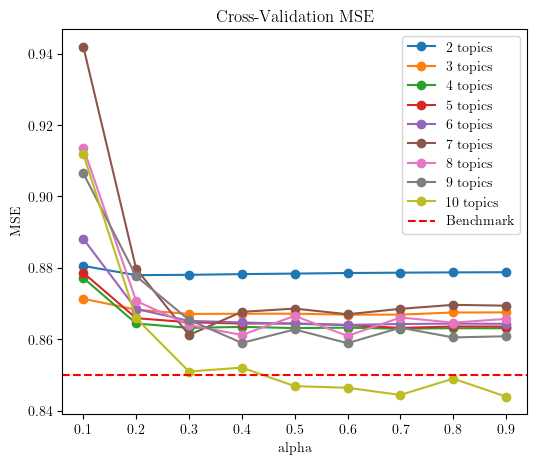

In [31]:
model.cv_mse_plot(benchmark = 0.85, figsize = (6, 5))

In [3]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=2, show_progress=True)

2024-04-03 12:13:44,045 [INFO] SNMF - Initial Assignment: [0 1 1]
2024-04-03 12:13:44,046 [INFO] FN: 6.977439325329257 (1 / 2)
2024-04-03 12:13:44,047 [INFO] FN: 6.929638965422419 (2 / 2)


In [4]:
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=2, show_progress=True)

2024-04-03 12:13:53,887 [INFO] SNMF - Initial Assignment: [0 1 1]
2024-04-03 12:13:53,887 [INFO] FN: 6.977439325329257 (1 / 2)
2024-04-03 12:13:53,888 [INFO] FN: 6.929638965422419 (2 / 2)


In [5]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=20, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

[[-7.50614717e-01  1.31635732e+00  1.24614003e+00 -1.60491574e+00
  -1.46814368e+00 -1.71507046e+00  1.85878369e+00  8.75879763e-02
  -5.23221964e-02  5.55471637e-01 -9.63403694e-01 -1.80321465e-01
  -1.18340916e+00  6.05445921e-01 -9.51650553e-01  3.60856060e-01
   1.06061026e+00 -1.17152178e-01  8.25664851e-01 -1.20981355e+00
  -1.19050362e+00  2.19871821e-01 -2.12919130e-01 -1.41149914e+00
  -4.82981016e-01  1.20176208e+00 -7.05803033e-01  2.51813547e-02
  -3.91128155e-01  1.93139124e-01  3.49290932e-01  5.91188382e-01
   5.20409870e-01  8.25222389e-01  4.26203507e-01  1.95640026e-01
  -5.14112178e-01 -3.07368882e+00 -3.95159070e-01 -7.95399184e-01
  -7.03201512e-01 -1.73739268e+00  7.50808258e-01 -1.86395314e+00
   4.18510984e-01 -2.35333837e-01  4.32107174e-01  8.70291930e-01
   2.00862219e+00  1.37177091e+00]
 [ 1.05859789e+00  1.44533756e+00  4.88232904e-02  9.03295203e-02
  -4.80256813e-01  3.00662736e-01  1.11297983e+00 -1.93150462e-02
  -8.07598399e-04 -6.38530234e-01  1.5946

In [6]:
print(W_test.shape)
print(W_test)
print(H_test)

(3, 2)
[[1.17797732 0.2087255 ]
 [0.34645526 0.84559617]
 [0.14539624 1.46598459]]
[[-0.80267244  1.36060009  0.90024422 -1.28755122 -1.41040407 -1.40454204
   1.75164169 -0.07776795  0.40059172  0.47474941 -0.65515775 -0.20559119
  -0.83270751  0.83826749 -0.8058675   0.3466136   0.80567418 -0.21366554
   0.83469297 -1.20397126 -1.22763569  0.30613543  0.05494692 -1.36912669
  -0.86629273  1.31277382 -0.73805959  0.13504014 -0.30046357 -0.48583546
   0.26397705  0.41342366  0.53045239  0.92354565  0.11736057 -0.23933129
  -0.69279653 -2.37885053 -0.22428498 -0.81647817 -0.74429769 -1.32292411
   0.55264664 -1.68885933  0.34056615 -0.16078402  0.42005637  0.7640741
   1.8728926   1.17709454]
 [ 1.24297945 -0.16167407  0.31355534  0.08413558  0.48627001  0.29518286
  -0.2229733   0.45078035 -1.3851298  -0.4643786   0.55468435  0.20502201
  -0.02297159 -1.22876441  0.41476171 -1.21695439  0.19508302  0.02750018
   0.18477192  1.19522359  0.71909032 -0.82094456 -1.23700905  1.08852179
   

In [14]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 50)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=True)
snmf_test.factorize(niter=20, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

Assign: [0 1 1]
H1: [[1.52 0.72]
 [0.72 2.92]] 
 H2: [[-3.79172008e-01  1.73962094e+00  1.68100032e+00 -1.97150936e+00
  -1.71235220e+00 -2.01106834e+00  2.36292594e+00  2.71948624e-01
  -5.70084607e-01  4.61363216e-01 -8.41362757e-01 -1.49418736e-01
  -1.43377236e+00  2.90903440e-01 -9.94002210e-01 -1.78080266e-01
   1.41398420e+00 -2.00301398e-01  1.23668978e+00 -1.00117009e+00
  -1.25901261e+00 -9.78832212e-02 -8.14390340e-01 -1.31483406e+00
  -2.69953001e-01  1.62585272e+00 -1.00859940e+00 -3.04023254e-01
  -8.15065329e-01  5.20160442e-01  5.74447002e-01  5.55301253e-01
   8.77528374e-01  7.39712344e-01  2.00454578e-01  4.28140366e-01
  -3.38505490e-01 -3.54784737e+00 -7.63029738e-01 -8.91433477e-01
  -1.15171695e+00 -1.86850089e+00  2.93910448e-01 -2.03317426e+00
   4.98841178e-01 -2.38177531e-01  6.39755345e-01  1.32674228e+00
   2.20639116e+00  1.07948270e+00]
 [ 2.97927097e+00  1.22322436e+00  1.36302175e+00 -5.94645968e-01
   2.89257694e-03 -6.09168210e-02  1.16606978e+00  1.0

In [16]:

print(W_test.shape)
print(W_test)
print(H_test)

(3, 2)
[[1.17797732 0.2087255 ]
 [0.34645526 0.84559617]
 [0.14539624 1.46598459]]
[[-0.80267244  1.36060009  0.90024422 -1.28755122 -1.41040407 -1.40454204
   1.75164169 -0.07776795  0.40059172  0.47474941 -0.65515775 -0.20559119
  -0.83270751  0.83826749 -0.8058675   0.3466136   0.80567418 -0.21366554
   0.83469297 -1.20397126 -1.22763569  0.30613543  0.05494692 -1.36912669
  -0.86629273  1.31277382 -0.73805959  0.13504014 -0.30046357 -0.48583546
   0.26397705  0.41342366  0.53045239  0.92354565  0.11736057 -0.23933129
  -0.69279653 -2.37885053 -0.22428498 -0.81647817 -0.74429769 -1.32292411
   0.55264664 -1.68885933  0.34056615 -0.16078402  0.42005637  0.7640741
   1.8728926   1.17709454]
 [ 1.24297945 -0.16167407  0.31355534  0.08413558  0.48627001  0.29518286
  -0.2229733   0.45078035 -1.3851298  -0.4643786   0.55468435  0.20502201
  -0.02297159 -1.22876441  0.41476171 -1.21695439  0.19508302  0.02750018
   0.18477192  1.19522359  0.71909032 -0.82094456 -1.23700905  1.08852179
   

In [10]:
np.random.seed(44)
# Generate a random matrix X 
X = np.random.randn(3, 5)
snmf_test = SNMF(X, num_bases=2, random_state=44, legacy_mode=False)
snmf_test.factorize(niter=1, show_progress=False)
H_test = snmf_test.H
W_test = snmf_test.W

print(X)
print(W_test.shape)
print(W_test)
print(H_test)

Assign: [0 1 1]
H1: [[1.52 0.72]
 [0.72 2.92]] 
 H2: [[-1.43643249  1.91532123  1.2762038  -1.81527414 -1.8410082 ]
 [-3.36429193  2.27742614 -1.06575741  0.34276532 -0.76904344]] 

W1: [[7.26156694 0.5343712 ]
 [2.67528366 2.80252752]
 [0.5343712  2.00662743]] 
 W2: [[7.26156694 0.53437121]
 [1.21026116 2.40457748]
 [1.99939371 2.40457748]]
[[-0.75061472  1.31635732  1.24614003 -1.60491574 -1.46814368]
 [-1.71507046  1.85878369  0.08758798 -0.0523222   0.55547164]
 [-0.96340369 -0.18032147 -1.18340916  0.60544592 -0.95165055]]
(3, 2)
[[1.2        0.2       ]
 [0.29735508 1.29549816]
 [0.10339567 1.09621371]]
[[-0.45206446  1.00841612  1.14639297 -1.4151509  -1.23011037]
 [-1.04068682  0.53128991 -0.64765765  0.4663267   0.03994385]]
